# Object Detection
See [Day 12：物體偵測(Object Detection) + 影像標題(Image Captioning)](https://ithelp.ithome.com.tw/articles/10192950?fbclid=IwAR35TCK77Jt7IN08M8vXwhvS5YfNtDwAmh9XlD8BghKBua4ttBQgjrcuT8o)

本程式來自[Martin Thoma](https://martin-thoma.com/object-detection/)，程式較長，不易說明，我將部分參數固定(Hard Code)，並加上註解，放在SSD資料夾，可在[這裡](https://github.com/mc6666/MyNeuralNetwork)找到，其中 weights_SSD300.hdf5 檔案過大，請自[mega](https://mega.nz/#F!7RowVLCL!q3cEVRK9jyOSB9el3SssIA) 下載，放在SSD資料夾中，再準備一組照片檔(*.jpg")，辨識內容限20類照片 -- 飛機、單車、鳥、小船、瓶子、巴士、轎車、貓、椅子、牛、餐桌、狗、馬、機車、人、盆栽、羊、沙發、火車、顯示器等，放在程式所在目錄下的images子目錄，然後執行ssd_test.py

In [1]:
"""
Run object detection with VOC classes.

This is just a minor modification of code from
https://github.com/rykov8/ssd_keras
"""

from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
# import matplotlib.image.imread as imread
import sys

from ssd import SSD300
from ssd_utils import BBoxUtility
import os
from os.path import basename

Using TensorFlow backend.


In [2]:
def create_overlay(img, results, voc_classes, plt_fname):
    plt.clf()
    # Parse the outputs.
    det_label = results[:, 0]
    det_conf = results[:, 1]
    det_xmin = results[:, 2]
    det_ymin = results[:, 3]
    det_xmax = results[:, 4]
    det_ymax = results[:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    currentAxis.axis('off')

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords,
                                            fill=False,
                                            edgecolor=color,
                                            linewidth=2))
        currentAxis.text(xmin, ymin, display_txt,
                         bbox={'facecolor': color, 'alpha': 0.5})
    plt.savefig(plt_fname)
    print("save "+plt_fname)

Instructions for updating:
Colocations handled automatically by placer.
process images\aa1.jpg
process images\aa2.jpg
process images\aa3.jpg
process images\bear and dog.jpg
process images\bird01.jpg
process images\elephant2.jpg
process images\input.jpg
前置處理...
預測...


c:\users\奎佑\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


7/7 [==============================] - 4s 512ms/step
results[0]=
0.9957736134529114
save results/aa1.png
save results/aa2.png
save results/aa3.png
save results/bear and dog.png
save results/bird01.png
save results/elephant2.png
save results/input.png


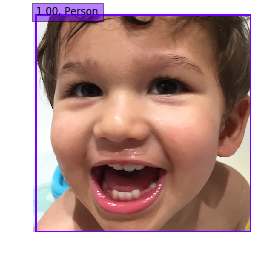

In [3]:
if __name__ == "__main__":
    import glob
    imagesList = glob.glob("images/*.jpg")

    # Load the model
    voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
                   'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
                   'Dog', 'Horse', 'Motorbike', 'Person', 'Pottedplant',
                   'Sheep', 'Sofa', 'Train', 'Tvmonitor']
    NUM_CLASSES = len(voc_classes) + 1
    input_shape = (300, 300, 3)
    model = SSD300(input_shape, num_classes=NUM_CLASSES)
    model.load_weights('weights_SSD300.hdf5', by_name=True)
    bbox_util = BBoxUtility(NUM_CLASSES)

    # Load the inputs
    inputs = []
    images = []
    for img_path in imagesList:
        print("process " + img_path)
        img = image.load_img(img_path, target_size=(300, 300))
        img = image.img_to_array(img)
        images.append(imread(img_path))
        inputs.append(img.copy())
    # 前置處理
    print("前置處理...")
    inputs = preprocess_input(np.array(inputs))

    # 預測
    print("預測...")
    preds = model.predict(inputs, batch_size=1, verbose=1)
    # 取得預測結果
    results = bbox_util.detection_out(preds)
    print("results[0]=")
    print(results[0][0][1])

    # create folder if not exist
    output_directory="results"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # proces images
    for i, img in enumerate(images):
        # 產生有框的 output files
        create_overlay(img, results[i], voc_classes,
           output_directory+"/{}.png".format(basename(os.path.splitext(imagesList[i])[0])))
    # Garbage collection, to prevent from TensorFlow error
    import gc
    gc.collect()

    